# K means from scratch - Oded Ben Chetrit

## Obtaining the data: 

In this assignment you will experience with partitional & mixture model clustering. The analyses are made on real datasets under the circumstances of real life challenges in unsupervised machine learning.

In [2]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use("bmh")

### Read blood test results as an EMR from an Excel file

In [3]:
# Open the file
xlsx = pd.ExcelFile('EMR-Blood.xlsx')

# Get the first sheet as an object
sheet1 = xlsx.parse(0)

# Set the Key column as the index
sheet1.set_index("Key", inplace=True)

# Show first 10 rows
sheet1[:10]

,Na,K,ALT,AST,WBC,RBC,Hgb,Hct
Key,,,,,,,,
1,141,4.65,31.92,35.01,10.25,4.06,17.6,36.3
2,140,4.96,36.41,16.70,6.13,3.80,13.2,35.6
3,136,3.66,41.43,13.17,5.86,4.26,16.2,43.7
4,136,4.74,23.92,30.33,10.80,4.83,16.1,49.8
5,140,4.74,43.66,20.44,6.59,4.05,12.6,39.1
6,146,3.98,48.41,33.22,4.53,4.04,17.9,47.3
7,144,5.29,44.29,19.28,10.12,3.96,17.2,47.9
8,138,4.57,50.43,16.39,4.66,4.91,13.7,41.5
9,144,3.96,31.51,34.87,4.57,4.72,15.1,47.6


### Blood Test Abbreviations
- Na == Sodium
- K == Potassium
- ALT == Alanine transaminase
- AST == Aspartate transaminase
- WBC == White blood cells
- RBC == Red blood cells
- Hgb == Hemoglobin
- Hct == Hematocrit

### Make a 3D plot:

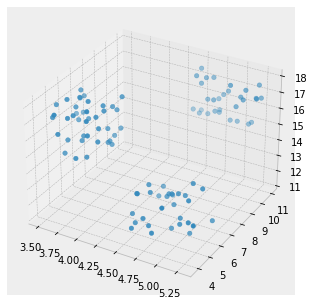

In [8]:
# Retrieve the K, WBC and Hgb column values from the dataset to cluster
variables1 = ["K","WBC","Hgb"]
EMR3d1 = sheet1.loc[:, variables1].values

def make_chart (chart_data, y_pred, labels):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(chart_data[:,0], chart_data[:,1], chart_data[:,2])

make_chart(EMR3d1, y_pred_KMeans1, variables1)

## K means from scratch with k++ initialization: 
Lloyd's Algorithm for solving the K-Means problem 
By examining the WCSS, I chose a proper threshold to determine algorithm convergence.

Ran evaluations on 'EMR-Blood.xlsx' dataset. 

In [5]:
# Add your code for Challenge 210 after this line, and keep it in this cell.

# helper function for computing WCSS: 
def WCSS(X, centroids, labels):
    
    # compute distances fo each point to it's centroid: 
    WCSS = np.sum((centroids[labels]-X)**2)
    
    # return the mean distance: 
    return WCSS

# Implement K-Means (X being the data)
class k_means:
    def __init__(self, k):
        self.k = k
    
    def fit(self, X):
        
        # assign samples to class:
        self.X = X
        
        #  initial centroids with k++ initialization: 
        
        # Choose random point in the data:  
        self.C = self.X[np.random.choice(self.X.shape[0], 1)]
        
        # iterate over k-1 to find k initial centroids: 
        for _ in range(self.k-1):
            
            # repeat X in new dimention according to number of centroids  
            X_3d = np.repeat(self.X[:, :, np.newaxis], self.C.shape[0] , axis=2)
            
            # distances for each point to each centroid:
            distances = np.sqrt(np.sum((X_3d - self.C.T)**2, axis = 1))
            
            # get labels per centroid: 
            labels = np.argmin(distances, axis = 1)
            
            # obtain new centroid by taking the longest distant point from all clusters:
            new_C = np.expand_dims(self.X[np.argmax(distances[np.arange(distances.shape[0]),labels])],axis=0)
            
            # concate the new C
            self.C = np.concatenate((self.C,new_C),axis = 0)
            
        # Now we have k centroids initialized with k++ algorithm we can run the Kmeans algorithm: 
        
        # Kmeans algorithm:
        
        # repeat X in new dimention according to number of centroids
        X_3d = np.repeat(self.X[:, :, np.newaxis], self.k , axis=2)
        
        # define stopping criterion for convergance: 
        self.Wcss = 10**10
        eps = 0.1
        
        # iterate: 
        for j in range(20):
            
            # distances for each point to each centroid:
            distances = np.sqrt(np.sum((X_3d - self.C.T)**2, axis = 1))
            
            # get labels per centroid: 
            labels = np.argmin(distances, axis = 1)
            
            # compute updated centroids: 
            self.C = np.array([np.mean(self.X[labels == i],axis = 0) for i in range(self.k)]) 
            
            # compute WCSS
            Wcss_new = WCSS(self.X, self.C, labels)
            
            # abort iteration if WCSS is not changing:
            if np.linalg.norm(Wcss_new-self.Wcss) < eps:
                
                # update WCSS
                self.Wcss = Wcss_new
                return self.C, self.Wcss
            
            self.Wcss = Wcss_new
        return self.C, self.Wcss
        
    def predict(self, X):
        
        # assign samples to test class:
        self.X_test = X
        
        # repeat X in new dimention according to number of centroids
        X_3d = np.repeat(self.X_test[:, :, np.newaxis], self.k , axis=2)
        
        # distances for each point to each centroid:
        distances = np.sqrt(np.sum((X_3d - self.C.T)**2, axis = 1))
        
        # get labels per centroid:
        labels = np.argmin(distances, axis = 1)
        
        return labels
    

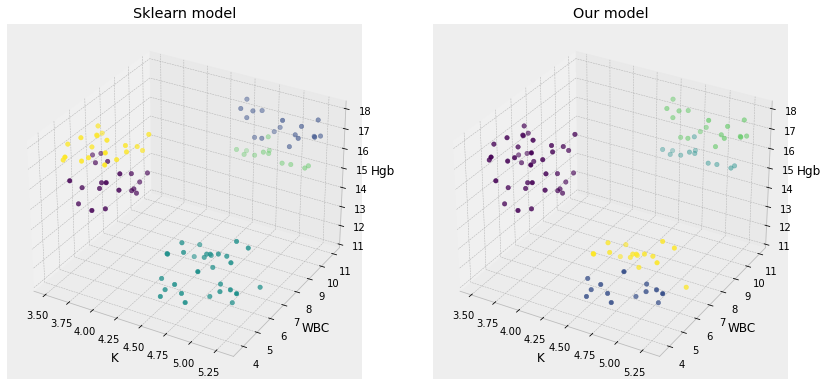

In [6]:
# Comparison between sklearn model and my model:

# Ran my model implementation with 5 centroids:
k = 5
my_k_means = k_means(k)
Centroids = my_k_means.fit(EMR3d1)
y_pred_KMeans2 = my_k_means.predict(EMR3d1)

# Plot the two outputs: 
fig = plt.figure(figsize = (14,7))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_xlabel(variables1[0])
ax.set_ylabel(variables1[1])
ax.set_zlabel(variables1[2])
ax.scatter(EMR3d1[:,0], EMR3d1[:,1], EMR3d1[:,2], c = y_pred_KMeans1 )
ax.set_title('Sklearn model')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_xlabel(variables1[0])
ax.set_ylabel(variables1[1])
ax.set_zlabel(variables1[2])
ax.scatter(EMR3d1[:,0], EMR3d1[:,1], EMR3d1[:,2], c = y_pred_KMeans2 )
ax.set_title('Our model')

plt.show()

I believe that the scikit KMeans algorithm might have the same initialization seeding everytime. I see that each time I initialize my classifier I get a slightly different clusters. Usually I get one main cluster and two other main areas that each have two sub-clusters. Sometimes based on the random initialization sample I get the same clusters the scikit classifier did, and sometimes not.

### Elbow method to find the optimal k:

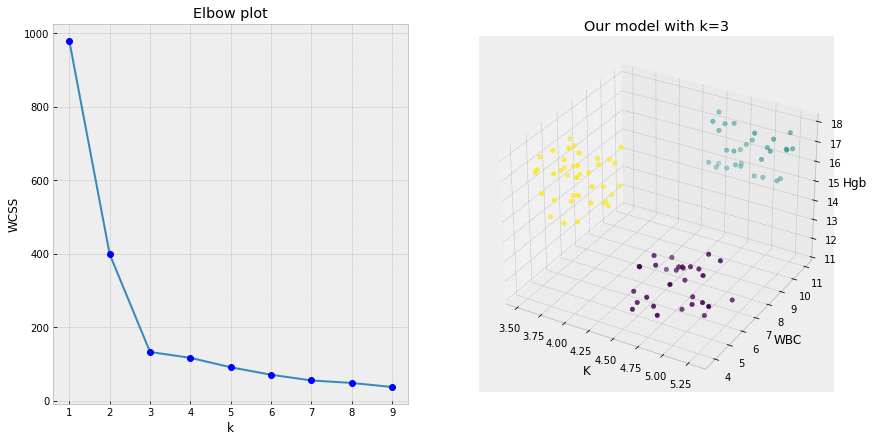

In [7]:
# run the algorithm for different k values and plot the elbow plot to select the right value of k: 
k_s = np.arange(1,10)
WCSS_scores = []

for k in k_s:
    
    # define the kmeans class with selected k:
    my_k_means = k_means(k)
    
    # find centroids using fit: 
    Centroids, WCSS_score = my_k_means.fit(EMR3d1)
    
    # predict labels using predict: 
    y_pred_KMeans2 = my_k_means.predict(EMR3d1)
    
    # compute distortion score and append in the list: 
    WCSS_scores.append(WCSS_score)

# Choose k = 3 accordng to the elbow plot.
k = 3
my_k_means = k_means(k)
Centroids, WCSS_score = my_k_means.fit(EMR3d1)
y_pred_KMeans2 = my_k_means.predict(EMR3d1)

# Plot the two outputs: 
fig = plt.figure(figsize = (14,7))

# plot elbow plot: 
ax = fig.add_subplot(1, 2, 1)
ax.plot(k_s, WCSS_scores)
ax.plot(k_s, WCSS_scores,'ob')
ax.set_title('Elbow plot')
ax.set_xlabel('k')
ax.set_ylabel('WCSS')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_xlabel(variables1[0])
ax.set_ylabel(variables1[1])
ax.set_zlabel(variables1[2])
ax.scatter(EMR3d1[:,0], EMR3d1[:,1], EMR3d1[:,2], c = y_pred_KMeans2 )
ax.set_title('Our model with k=3')

plt.show()


### Optimal k = 3